# Training RL Agent in Maze Gridworld with Value-iteration method

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import List
import gym
from pathlib import Path

## Environment

In [ ]:
class MazeEnv(gym.Env):
    def __init__(self, stochastic=True):
        """Stochastic Maze environment with coins, obstacles/walls and a goal state.
        Actions: 0: Move Up, 1: Move Down, 2: Move Left, 3: Move Right
        Reward is based on the number of coins collected by the agent before reaching goal state.
        Stochasticity in the env arises from the `slip_probability` which alters the action.
          The slip action will be the clockwise directinal action (LEFT -> UP, UP -> RIGHT etc)
          Example with `slip_probability=0.2`: With 0.2 probabilty a "RIGHT" action may result in "DOWN"
        """
        self.map = np.asarray(["SWFWG", "OOOOO", "WOOOW", "FOWFW"])
        self.observation_space = gym.spaces.Discrete(1)
        self.dim = (4, 5)  # Used for plotting policy & value function
        self.img_map = np.ones(self.dim)
        self.obstacles = [(0, 1), (0, 3), (2, 0), (2, 4), (3, 2), (3, 4)]
        for x in self.obstacles:
            self.img_map[x[0]][x[1]] = 0
        if stochastic:
            self.slip = True
        self.distinct_states = 112  # Number of unique states in the env
        self.action_space = gym.spaces.Discrete(4)
        # Clock-wise action slip for stochasticity
        self.slip_action_map = {
            0: 3,
            1: 2,
            2: 0,
            3: 1,
        }
        self.slip_probability = 0.1
        self.start_pos = (0, 0)
        self.goal_pos = (0, 4)
        self.index_to_coordinate_map = {
            0: (0, 0),
            1: (1, 0),
            2: (3, 0),
            3: (1, 1),
            4: (2, 1),
            5: (3, 1),
            6: (0, 2),
            7: (1, 2),
            8: (2, 2),
            9: (1, 3),
            10: (2, 3),
            11: (3, 3),
            12: (0, 4),
            13: (1, 4),
        }
        self.coordinate_to_index_map = dict(
            (val, key) for key, val in self.index_to_coordinate_map.items()
        )
        # Start state
        self.state = self.coordinate_to_index_map[self.start_pos]

    def set_state(self, state: int) -> None:
        """Set the current state of the environment. Useful for value iteration
        Args:
            state (int): A valid state in the Maze env int: [0, 112]
        """
        self.state = state

    def step(self, action, slip=True):
        """Run one step into the Maze env
        Args:
            state (Any): Current index state of the maze
            action (int): Discrete action for up, down, left, right
            slip (bool, optional): Stochasticity in the env. Defaults to True.
        Raises:
            ValueError: If invalid action is provided as input
        Returns:
            Tuple : Next state, reward, done, _
        """
        self.slip = slip
        if self.slip:
            if np.random.rand() < self.slip_probability:
                action = self.slip_action_map[action]

        cell = self.index_to_coordinate_map[int(self.state / 8)]
        if action == 0:
            c_next = cell[1]
            r_next = max(0, cell[0] - 1)
        elif action == 1:
            c_next = cell[1]
            r_next = min(self.dim[0] - 1, cell[0] + 1)
        elif action == 2:
            c_next = max(0, cell[1] - 1)
            r_next = cell[0]
        elif action == 3:
            c_next = min(self.dim[1] - 1, cell[1] + 1)
            r_next = cell[0]
        else:
            raise ValueError(f"Invalid action:{action}")

        if (r_next == self.goal_pos[0]) and (
            c_next == self.goal_pos[1]
        ):  # Check if goal reached
            v_coin = self.num2coin(self.state % 8)
            self.state = (
                8 * self.coordinate_to_index_map[(r_next, c_next)] + self.state % 8
            )
            return (
                self.state,
                float(sum(v_coin)),
                True,
            )
        else:
            if (r_next, c_next) in self.obstacles:  # obstacle tuple list
                return self.state, 0.0, False
            else:  # Coin locations
                v_coin = self.num2coin(self.state % 8)
                if (r_next, c_next) == (0, 2):
                    v_coin[0] = 1
                elif (r_next, c_next) == (3, 0):
                    v_coin[1] = 1
                elif (r_next, c_next) == (3, 3):
                    v_coin[2] = 1
                self.state = 8 * self.coordinate_to_index_map[
                    (r_next, c_next)
                ] + self.coin2num(v_coin)
                return (
                    self.state,
                    0.0,
                    False,
                )

    def num2coin(self, n: int):
        # Each element of the below tuple correspond to a status of each coin. 0 for not collected, 1 for collected.
        coinlist = [
            (0, 0, 0),
            (1, 0, 0),
            (0, 1, 0),
            (0, 0, 1),
            (1, 1, 0),
            (1, 0, 1),
            (0, 1, 1),
            (1, 1, 1),
        ]
        return list(coinlist[n])

    def coin2num(self, v: List):
        if sum(v) < 2:
            return np.inner(v, [1, 2, 3])
        else:
            return np.inner(v, [1, 2, 3]) + 1

    def reset(self):
        # Return the initial state
        self.state = self.coordinate_to_index_map[self.start_pos]
        return self.state

    def render(self):
        cell = self.index_to_coordinate_map[int(self.state / 8)]
        desc = self.map.tolist()

        desc[cell[0]] = (
            desc[cell[0]][: cell[1]]
            + "\x1b[1;34m"  # Blue font
            + "\x1b[4m"  # Underline
            + "\x1b[1m"  # Bold
            + "\x1b[7m"  # Reversed
            + desc[cell[0]][cell[1]]
            + "\x1b[0m"
            + desc[cell[0]][cell[1] + 1 :]
        )

        print("\n".join("".join(row) for row in desc))

## Visualization function

In [ ]:
def visualize_maze_values(q_table, env, isMaze=True, arrow=True):
    """Plot the Tabular Q-Value function
    Args:
        q_table (np.array): Tabular Q-Value function
        env (gym.Env): Gym environment with discrete space. E.g: MazeEnv
        isMaze (bool, optional): True for MazeEnv. Defaults to True.
        arrow (bool, optional): Set to True for drawing directional arrows. Defaults to True.
    """
    # (x,y) cooridnates
    direction = {
        0: (0, -0.4),
        1: (0, 0.4),
        2: (-0.4, 0),
        3: (0.4, 0),
    }
    v = np.max(q_table, axis=1)
    best_action = np.argmax(q_table, axis=1)
    if isMaze:
        idx2cell = env.index_to_coordinate_map
        for i in range(8):
            _, ax = plt.subplots()
            ax.set_axis_off()
            y_mat = np.zeros(env.dim)
            for j in range(len(idx2cell)):
                pos = idx2cell[j]
                y_mat[pos[0], pos[1]] = v[8 * j + i]
                if arrow:
                    a = best_action[8 * j + i]
                    ax.arrow(
                        pos[1],
                        pos[0],
                        direction[a][0],
                        direction[a][1],
                        head_width=0.05,
                        head_length=0.1,
                        fc="g",
                        ec="g",
                    )
            y_mat[env.goal_pos] = max(v) + 0.1
            ax.imshow(y_mat, cmap="hot")
            plt.savefig(f"results/value_iter_{i}.png", bbox_inches="tight")

    else:
        n = int(np.sqrt(len(v)))
        state_value_func = np.zeros((n, n))
        for r in range(n):
            for c in range(n):
                if not (r == (n - 1) and c == (n - 1)):
                    state_value_func[r, c] = v[n * c + r]
                    if arrow:
                        d = direction[best_action[n * c + r]]
                        plt.arrow(
                            c,
                            r,
                            d[0],
                            d[1],
                            head_width=0.05,
                            head_length=0.1,
                            fc="r",
                            ec="r",
                        )
        state_value_func[env.goal_pos] = max(v[:-1]) + 0.1
        plt.imshow(state_value_func, cmap="hot")
    plt.show()

## Value Iteration method

In [ ]:
discount = 0.9
iters = 1000

In [ ]:
env = MazeEnv()
state_dim = env.distinct_states
state_values = np.zeros(state_dim)
q_values = np.zeros((state_dim, env.action_space.n))  # Action values
policy = np.zeros(state_dim)

In [ ]:
def calculate_values(state, action):
    """Evaluate Value function for given state and action

    Args:
        state (int): Valid (discrete) state in discrete `env.observation_space`
        action (int): Valid (discrete) action in `env.action_space`

    Returns:
        v_sum: value for given state, action
    """
    v_sum = 0
    transitions = []
    slip_action = env.slip_action_map[action]
    env.set_state(state)
    slip_next_state, slip_reward, _ = env.step(slip_action, slip=False)
    transitions.append((slip_reward, slip_next_state, env.slip_probability))
    env.set_state(state)
    next_state, reward, _ = env.step(action, slip=False)
    transitions.append((reward, next_state, 1 - env.slip_probability))
    for reward, next_state, pi in transitions:
        v_sum += pi * (reward + discount * state_values[next_state])
    return v_sum

In [ ]:
# Value Iteration
for i in range(iters):
    v_s = np.zeros(state_dim)
    for state in range(state_dim):
        if env.index_to_coordinate_map[int(state / 8)] == env.goal_pos:
            continue
        v_max = float("-inf")
        for action in range(env.action_space.n):
            v_sum = calculate_values(state, action)
            v_max = max(v_max, v_sum)
        v_s[state] = v_max
    state_values = np.copy(v_s)

In [ ]:
for state in range(state_dim):
    for action in range(env.action_space.n):
        q_values[state, action] = calculate_values(state, action)

In [ ]:
for state in range(state_dim):
    policy[state] = np.argmax(q_values[state, :])

Action mapping:[0 - UP; 1 - DOWN; 2 - LEFT; 3 - RIGHT
Optimal actions:
[1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 3. 1. 3. 1. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 3. 3. 0. 0. 2. 2. 0. 2. 0. 2. 0. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 3. 0. 0. 3. 3. 0. 3. 0. 3. 0. 0. 3. 0. 0. 0.
 1. 1. 2. 2. 3. 3. 3. 3. 1. 1. 1. 2. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 2. 0. 0. 0. 0. 0.]


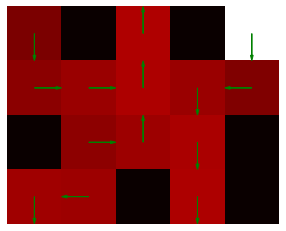

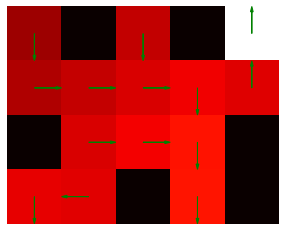

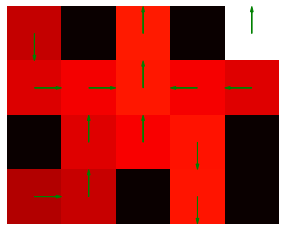

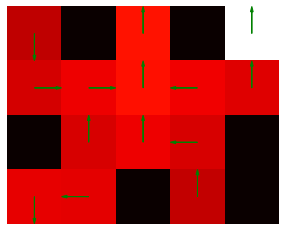

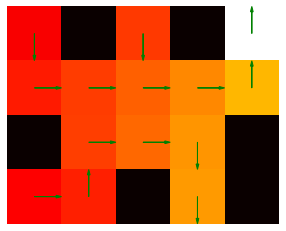

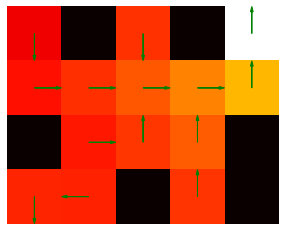

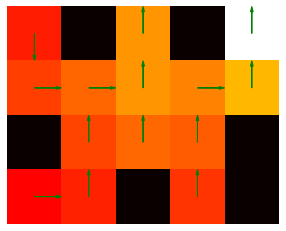

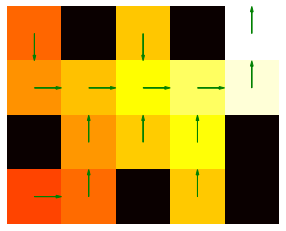

In [ ]:
Path("results").mkdir(exist_ok=True)
np.save("results/q_values", q_values)
np.save("results/optimal_policy", policy)
# print(q_values)
print("Action mapping:[0 - UP; 1 - DOWN; 2 - LEFT; 3 - RIGHT")
print("Optimal actions:")
print(policy)
visualize_maze_values(q_values, env)

---

In [ ]:
!apt-get -qq install tree
!rm -r sample_data

In [ ]:
!tree -h --du .

.
└── [ 32K]  results
    ├── [1.0K]  optimal_policy.npy
    ├── [3.6K]  q_values.npy
    ├── [2.9K]  value_iter_0.png
    ├── [2.9K]  value_iter_1.png
    ├── [2.9K]  value_iter_2.png
    ├── [2.9K]  value_iter_3.png
    ├── [2.9K]  value_iter_4.png
    ├── [2.9K]  value_iter_5.png
    ├── [2.9K]  value_iter_6.png
    └── [2.9K]  value_iter_7.png

  36K used in 1 directory, 10 files


In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-02 10:01:03

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython   : 5.5.0
matplotlib: 3.2.2
numpy     : 1.19.5
seaborn   : 0.11.2
gym       : 0.17.3



---

**END**